In [4]:
file_path = "DataSet_Misinfo_FAKE.csv"  # Or whatever actual filename is in the dataset
FAKE = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "stevenpeutz/misinformation-fake-news-text-dataset-79k",
    file_path,
)


/tmp/ipykernel_28763/1410629997.py:2: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  FAKE = kagglehub.load_dataset(


In [5]:
file_path = "DataSet_Misinfo_TRUE.csv"  # Or whatever actual filename is in the dataset
TRUE = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "stevenpeutz/misinformation-fake-news-text-dataset-79k",
    file_path,
)

/tmp/ipykernel_28763/1406985085.py:2: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  TRUE = kagglehub.load_dataset(


100%|██████████████████████████████████████████████████████████████████████████████| 41.0M/41.0M [00:00<00:00, 76.5MB/s]

Extracting zip of DataSet_Misinfo_TRUE.csv...


In [7]:
FAKE.head()

,Unnamed: 0,text
0,0,Donald Trump just couldn t wish all Americans ...
1,1,House Intelligence Committee Chairman Devin Nu...
2,2,"On Friday, it was revealed that former Milwauk..."
3,3,"On Christmas day, Donald Trump announced that ..."
4,4,Pope Francis used his annual Christmas Day mes...


In [8]:
TRUE.head()

,Unnamed: 0,text
0,0,The head of a conservative Republican faction ...
1,1,Transgender people will be allowed for the fir...
2,2,The special counsel investigation of links bet...
3,3,Trump campaign adviser George Papadopoulos tol...
4,4,President Donald Trump called on the U.S. Post...


In [15]:
import numpy as np
import pandas as pd

from tabulate import tabulate
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import seaborn as sns
from textblob import TextBlob

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer

import string
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import nltk

# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

True news dataset shape: (34975, 2)
Fake news dataset shape: (43642, 2)


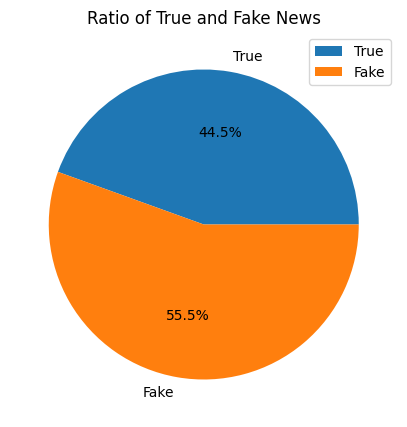

Features in 'True' Dataset:
 ['Unnamed: 0', 'text'] 

Features in 'Fake' Dataset:
 ['Unnamed: 0', 'text'] 



In [19]:
# Print shape
print("True news dataset shape:", TRUE.shape)
print("Fake news dataset shape:",FAKE.shape)

# Graph pie chart displaying ratio of true and fake news
plt.figure(figsize=(5,5))
plt.title('Ratio of True and Fake News')
plt.axis('equal')
plt.pie([TRUE.shape[0],FAKE.shape[0]],labels=['True','Fake'],autopct='%1.1f%%')
plt.legend()
plt.show()

# Print feature names (column names) for both datasets
print("Features in 'True' Dataset:\n", TRUE.columns.tolist(), "\n")
print("Features in 'Fake' Dataset:\n", FAKE.columns.tolist(), "\n")

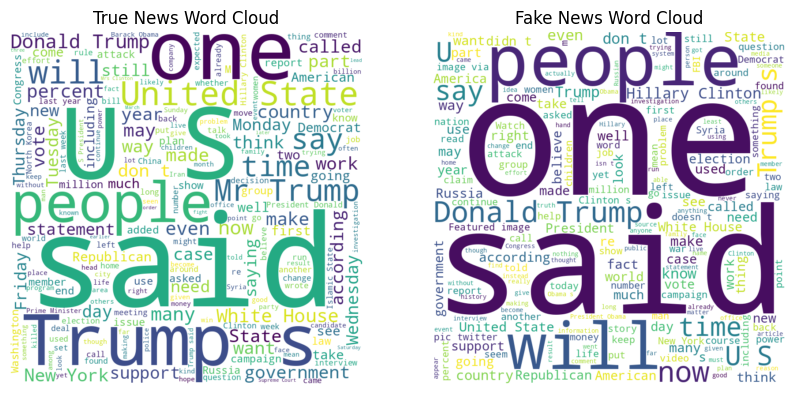

In [16]:
true_text = ' '.join(TRUE['text'].astype(str))
fake_text = ' '.join(FAKE['text'].astype(str))

true_wordcloud = WordCloud(width=800, height=800, background_color='white').generate(true_text)
fake_wordcloud = WordCloud(width=800, height=800, background_color='white').generate(fake_text)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(true_wordcloud, interpolation='bilinear')
plt.axis('off')
plt
plt.title('True News Word Cloud')

plt.subplot(1, 2, 2)
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News Word Cloud')

plt.show()

In [21]:
from wordcloud import WordCloud

# Get the top 10 words and their weights
top_twords = sorted(true_wordcloud.words_.items(), key=lambda x: x[1], reverse=True)[:10]

for word, weight in top_twords:
    print(f"{word}: {weight:.4f}")


said: 1.0000
U S: 0.5621
one: 0.3696
Trump s: 0.2681
people: 0.2639
United State: 0.2626
will: 0.2515
Mr Trump: 0.2247
say: 0.2046
time: 0.2032


In [22]:
from wordcloud import WordCloud

# Get the top 10 words and their weights
top_fwords = sorted(fake_wordcloud.words_.items(), key=lambda x: x[1], reverse=True)[:10]

for word, weight in top_fwords:
    print(f"{word}: {weight:.4f}")


one: 1.0000
said: 0.9722
people: 0.9309
will: 0.7541
Donald Trump: 0.6618
now: 0.6429
say: 0.5932
U: 0.5688
U S: 0.5583
time: 0.5520


In [ ]:
## I think something intereresting for our NLP work could be finding out what the context of these ten words are in both the true and 
## fake news data so that we can produce some insights about true/fake news ie. while both data sets have the US in the top 10 maybe analyzing what the
## words preceding or following are the compare / contrast the context
## Also the fake top 10 has the word now so is there some sort of language of fear / urgency being perpetuated in fake news

In [23]:
# Summary of blank and missing entries in true data
summary_true = {
    "Blank Text Entries": (TRUE['text'].str.strip() == '').sum(),
    "Missing Entries (NaN)": TRUE.isna().sum().sum(),
}

# Convert dictionary to a DataFrame for better tabulation
summary_df = pd.DataFrame(list(summary_true.items()), columns=["Entry Type", "Count"])

# Display the summary in tabular format
print(tabulate(summary_df, headers="keys", tablefmt="grid"))

+----+-----------------------+---------+
|    | Entry Type            |   Count |
+====+=======================+=========+
|  0 | Blank Text Entries    |       0 |
+----+-----------------------+---------+
|  1 | Missing Entries (NaN) |      29 |
+----+-----------------------+---------+


In [24]:
summary_fake = {
    "Blank Text Entries": (FAKE['text'].str.strip() == '').sum(),
    "Missing Entries (NaN)": c.sum().sum(),
}

# Convert dictionary to a DataFrame for better tabulation
summary_df = pd.DataFrame(list(summary_fake.items()), columns=["Entry Type", "Count"])

# Display the summary in tabular format
print(tabulate(summary_df, headers="keys", tablefmt="grid"))

+----+-----------------------+---------+
|    | Entry Type            |   Count |
+====+=======================+=========+
|  0 | Blank Text Entries    |       0 |
+----+-----------------------+---------+
|  1 | Missing Entries (NaN) |       0 |
+----+-----------------------+---------+


In [25]:
# duplicate identification
true_duplicates = TRUE.duplicated().sum()
fake_duplicates = FAKE.duplicated().sum()

print("Number of Duplicates in 'True' Dataset:", true_duplicates)
print("Number of Duplicates in 'Fake' Dataset:", fake_duplicates)

Number of Duplicates in 'True' Dataset: 0
Number of Duplicates in 'Fake' Dataset: 0


In [39]:
indices = TRUE[TRUE.isna().any(axis=1)].index
true_cleaned = TRUE.drop(indices)

index = FAKE[FAKE.isna().any(axis=1)].index
fake_cleaned = FAKE.drop(index)

# Print shape
print("True news dataset shape:",true_cleaned.shape)
print("Fake news dataset shape:",fake_cleaned.shape)

True news dataset shape: (34946, 2)
Fake news dataset shape: (43642, 2)


In [ ]:
## FROM HERE ON ONWARDS Access the datasets TRUE and FAKE using true_cleaned and fake_cleaned

In [41]:
true_text = ' '.join(true_cleaned['text'].astype(str))
fake_text = ' '.join(fake_cleaned['text'].astype(str))
all_text = [true_text, fake_text]

# Initialize CountVectorizer with stopword removal
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the data
true_counts = vectorizer.fit_transform([true_text])
fake_counts = vectorizer.fit_transform([fake_text])

# Fit on all text and transform each text separately
vectorizer.fit(all_text)
true_counts = vectorizer.transform([true_text])
fake_counts = vectorizer.transform([fake_text])

# Convert to DataFrames
true_word_freq = pd.DataFrame(true_counts.toarray(), columns=vectorizer.get_feature_names_out()).T
fake_word_freq = pd.DataFrame(fake_counts.toarray(), columns=vectorizer.get_feature_names_out()).T

# Add column names for clarity
true_word_freq.columns = ['Frequency']
fake_word_freq.columns = ['Frequency']

# Get top 10 most frequent words for true and fake news
top_true = true_word_freq.sort_values(by='Frequency', ascending=False).head(10)
top_fake = fake_word_freq.sort_values(by='Frequency', ascending=False).head(10)

In [42]:
# Display top 10 most frequent words for true news
print("Top 10 Most Frequent Words in True News:")
print(tabulate(top_true.reset_index(), headers=['Word', 'Frequency'], tablefmt='grid'))

Top 10 Most Frequent Words in True News:
+----+------------+-------------+
|    | Word       |   Frequency |
+====+============+=============+
|  0 | said       |      167563 |
+----+------------+-------------+
|  1 | trump      |       97504 |
+----+------------+-------------+
|  2 | mr         |       65810 |
+----+------------+-------------+
|  3 | president  |       47906 |
+----+------------+-------------+
|  4 | new        |       38841 |
+----+------------+-------------+
|  5 | people     |       38668 |
+----+------------+-------------+
|  6 | state      |       35679 |
+----+------------+-------------+
|  7 | states     |       28839 |
+----+------------+-------------+
|  8 | government |       26994 |
+----+------------+-------------+
|  9 | clinton    |       26561 |
+----+------------+-------------+


In [43]:
# Display top 10 most frequent words for fake news
print("\nTop 10 Most Frequent Words in Fake News:")
print(tabulate(top_fake.reset_index(), headers=['Word', 'Frequency'], tablefmt='grid'))


Top 10 Most Frequent Words in Fake News:
+----+-----------+-------------+
|    | Word      |   Frequency |
+====+===========+=============+
|  0 | trump     |      106401 |
+----+-----------+-------------+
|  1 | said      |       49840 |
+----+-----------+-------------+
|  2 | people    |       49396 |
+----+-----------+-------------+
|  3 | clinton   |       45330 |
+----+-----------+-------------+
|  4 | president |       39535 |
+----+-----------+-------------+
|  5 | just      |       34775 |
+----+-----------+-------------+
|  6 | like      |       31951 |
+----+-----------+-------------+
|  7 | hillary   |       31526 |
+----+-----------+-------------+
|  8 | new       |       28880 |
+----+-----------+-------------+
|  9 | obama     |       28668 |
+----+-----------+-------------+


In [ ]:
## the top 10 words from the word cloud and this tabular computation is different maybe we should investigate that?

In [44]:
# Combine and compare frequencies
comparison = pd.concat([true_word_freq, fake_word_freq], axis=1, keys=['True', 'Fake']).fillna(0)
comparison.columns = ['True_Frequency', 'Fake_Frequency']
comparison['Difference'] = comparison['True_Frequency'] - comparison['Fake_Frequency']

# Get top 10 most divergent words
top_divergent = comparison.sort_values(by='Difference', ascending=False).head(10)

# Display results with tabulate
print("Top 10 Most Divergent Words:")
print(tabulate(top_divergent.reset_index(), headers=['Word', 'True_Frequency', 'Fake_Frequency', 'Difference'], tablefmt='grid'))

Top 10 Most Divergent Words:
+----+------------+------------------+------------------+--------------+
|    | Word       |   True_Frequency |   Fake_Frequency |   Difference |
+====+============+==================+==================+==============+
|  0 | said       |           167563 |            49840 |       117723 |
+----+------------+------------------+------------------+--------------+
|  1 | mr         |            65810 |             6319 |        59491 |
+----+------------+------------------+------------------+--------------+
|  2 | ms         |            12573 |             1032 |        11541 |
+----+------------+------------------+------------------+--------------+
|  3 | republican |            24186 |            12752 |        11434 |
+----+------------+------------------+------------------+--------------+
|  4 | house      |            26381 |            16155 |        10226 |
+----+------------+------------------+------------------+--------------+
|  5 | united     |   

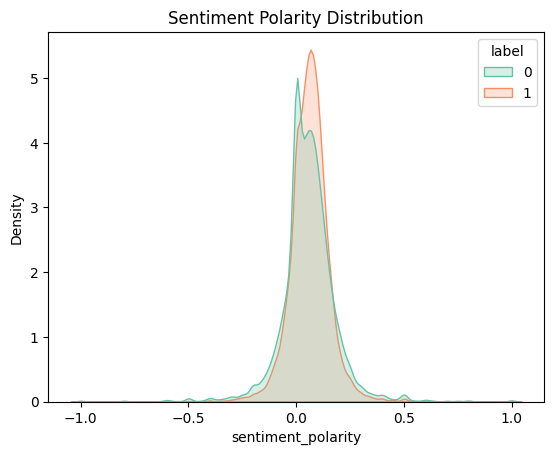

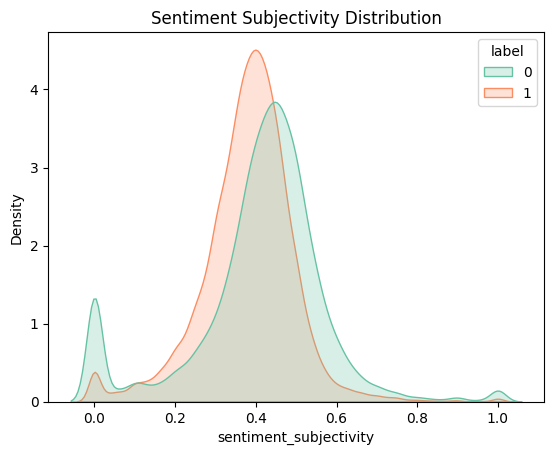

In [46]:
# Add sentiment scores
true_cleaned['label'] = 1
fake_cleaned['label'] = 0
all_news = pd.concat([true_cleaned, fake_cleaned], ignore_index=True)

all_news['sentiment_polarity'] = all_news['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
all_news['sentiment_subjectivity'] = all_news['text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

# Compare polarity and subjectivity
sns.kdeplot(data=all_news, x='sentiment_polarity', hue='label', fill=True, common_norm=False, palette='Set2')
plt.title("Sentiment Polarity Distribution")
plt.show()

sns.kdeplot(data=all_news, x='sentiment_subjectivity', hue='label', fill=True, common_norm=False, palette='Set2')
plt.title("Sentiment Subjectivity Distribution")
plt.show()

Explaining the results of these two graphs a bit:
Polarity scores are assigned -1 to 1 scaling extrememly negative to extrememly positive (0 being neutral)
Subjectivity scores are assigned 0 to 1 scaling very objective to very subjective

Below We see that fake news actually has a more neutral tone but is slightly more subjective compared to true news

In [50]:
# Get summary stats of polarity and subjectivity grouped by the binary class
summary_stats = all_news.groupby('label')[['sentiment_polarity', 'sentiment_subjectivity']].describe()
print(summary_stats)

      sentiment_polarity                                               \
                   count      mean       std  min       25%       50%   
label                                                                   
0                43642.0  0.055009  0.130537 -1.0  0.000000  0.051501   
1                34946.0  0.061227  0.094608 -1.0  0.009149  0.061653   

                     sentiment_subjectivity                           \
            75%  max                  count      mean       std  min   
label                                                                  
0      0.114621  1.0                43642.0  0.409269  0.165773  0.0   
1      0.110000  1.0                34946.0  0.379394  0.115340  0.0   

                                          
            25%       50%       75%  max  
label                                     
0      0.351864  0.431894  0.499877  1.0  
1      0.322367  0.388192  0.445887  1.0  


In [ ]:
## I think another interesting NLP task would maybe be to compare objectivity of true vs fake news on different topics
## ie Ukraine, abortion, voter fraud, trump policies, etc.

## maybe we can do an unsupervised learning using NLP to divide the true and fake news based off of clusters that classify the issues
## then we can compare sentiment

In [47]:
all_news = all_news.sample(frac=1, random_state=42).reset_index(drop=True)
all_news.head()

#I think the unanmed: 0 column is the indicy of the data in its original data set (true/false) - will have to confirm

,Unnamed: 0,text,label,sentiment_polarity,sentiment_subjectivity
0,30907,"TORONTO — As soon as Bayan Mohammad, a S...",1,0.056712,0.442713
1,34269,Donald Trump clinched the Republican nominatio...,1,0.100599,0.551938
2,16365,The Catalan government s business head resigne...,1,0.075000,0.525000
3,21576,Fox News host Megyn Kelly shut down a liberal ...,0,-0.070326,0.399206
4,6726,It s a wonder why Donald Trump has been divorc...,0,0.174010,0.485355
